In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

n = 50000

unique_judge_ids = np.arange(100, 100 + n) 

np.random.shuffle(unique_judge_ids)

data = {
    "Case ID": range(1, n + 1),
    "Gender": np.random.choice(["Male", "Female"], n),
    "Age": np.random.randint(18, 70, n),
    "Race/Ethnicity": np.random.choice(["White", "Black", "Asian", "Hispanic", "Other"], n),
    "Socioeconomic Status": np.random.choice(["Lower Class", "Middle Class", "Upper Class"], n),
    "Case Type": np.random.choice(["Theft", "Fraud", "Assault", "Drug Offense", "Other"], n),
    "Sentence Type": np.random.choice(["Prison", "Fine", "Probation"], n),
    "Sentence Length (Months)": np.random.randint(1, 120, n),  # Extended to 1-120 months
    "Region": np.random.choice(["North", "South", "East", "West"], n),
    "Judge ID": unique_judge_ids[:n],  # Assign unique shuffled Judge IDs
    "Number of Adjournments": np.random.randint(0, 10, n),  # New feature: procedural delays
    "Legal Representation": np.random.choice(["Private Lawyer", "Public Defender", "No Representation"], n),  # New feature
    "Prior Convictions": np.random.randint(0, 5, n),  # New feature: criminal history
    "Appealed": np.random.choice(["Yes", "No"], n),  # New feature: whether the case was appealed
    "Mitigating Factors": np.random.choice(["Yes", "No"], n),  # New feature: presence of mitigating factors
    "Aggravating Factors": np.random.choice(["Yes", "No"], n),  # New feature: presence of aggravating factors
}

df = pd.DataFrame(data)

df.to_csv("agni_adyant_lostdevs_syndata.csv", index=False)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Resampled Dataset Shape: (50088, 10)
Selected Features: ['Number of Adjournments']

Random Forest Classification Report (Overall):
              precision    recall  f1-score   support

        Fine       0.34      0.31      0.32      5009
      Prison       0.34      0.31      0.32      5009
   Probation       0.34      0.41      0.37      5009

    accuracy                           0.34     15027
   macro avg       0.34      0.34      0.34     15027
weighted avg       0.34      0.34      0.34     15027


Classification Report (Male):
              precision    recall  f1-score   support

        Fine       0.34      0.41      0.37      2546
      Prison       0.34      0.31      0.32      2517
   Probation       0.34      0.31      0.32      2587

    accuracy                           0.34      7650
   macro avg       0.34      0.34      0.34      7650
weighted avg       0.34      0.34      0.34      7650


Classification Report (Female):
              precision    recall  f1-score

C:\Users\whora\AppData\Local\Temp\ipykernel_20616\980569784.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perm_importance.importances_mean, y=selected_features, palette='viridis')


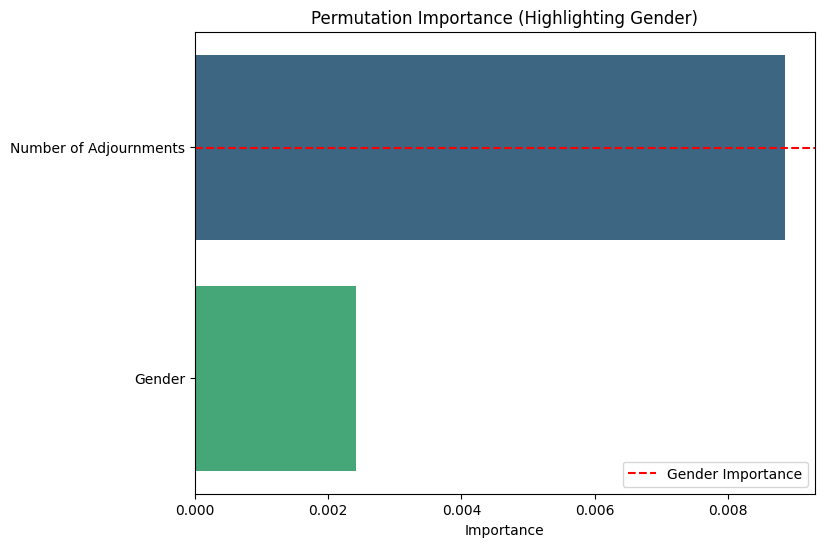


Gender Feature Importance: 0.002
Gender has limited influence on sentencing decisions.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearnex.ensemble import RandomForestClassifier as IntelRandomForest
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearnex import patch_sklearn

patch_sklearn()

df = pd.read_csv("agni_adyant_lostdevs_syndata.csv")

categorical_columns = ['Gender', 'Race/Ethnicity', 'Socioeconomic Status', 'Case Type',
                       'Region', 'Legal Representation', 'Appealed', 'Mitigating Factors', 'Aggravating Factors']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

features = ['Gender', 'Race/Ethnicity', 'Socioeconomic Status', 'Case Type', 'Region',
            'Legal Representation', 'Prior Convictions', 'Number of Adjournments', 
            'Mitigating Factors', 'Aggravating Factors']
target = 'Sentence Type'

X = df[features]
y = df[target]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Resampled Dataset Shape:", X_resampled.shape)

rf_model = IntelRandomForest(n_estimators=100, random_state=42, n_jobs=-1)
rfecv = RFECV(estimator=rf_model, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_resampled, y_resampled)

selected_features = [features[i] for i in range(len(features)) if rfecv.support_[i]]
print("Selected Features:", selected_features)


if "Gender" not in selected_features:
    selected_features.append("Gender")


X_selected = X_resampled[selected_features]


X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

l
print("\nRandom Forest Classification Report (Overall):")
print(classification_report(y_test, y_pred_rf))


X_test_with_gender = X_test.copy()
X_test_with_gender['Gender'] = X_test['Gender'].values  # Keep the correct Gender column


male_subset = X_test_with_gender[X_test_with_gender['Gender'] == 0]  # 0 corresponds to Male
y_pred_male = rf_model.predict(male_subset[selected_features])
print("\nClassification Report (Male):")
print(classification_report(y_test[male_subset.index], y_pred_male))

female_subset = X_test_with_gender[X_test_with_gender['Gender'] == 1]  # 1 corresponds to Female
y_pred_female = rf_model.predict(female_subset[selected_features])
print("\nClassification Report (Female):")
print(classification_report(y_test[female_subset.index], y_pred_female))

perm_importance = permutation_importance(rf_model, X_test[selected_features], y_test, n_repeats=10, random_state=42, n_jobs=-1)
gender_index = selected_features.index("Gender")

plt.figure(figsize=(8, 6))
sns.barplot(x=perm_importance.importances_mean, y=selected_features, palette='viridis')
plt.axhline(y=perm_importance.importances_mean[gender_index], color='red', linestyle='--', label='Gender Importance')
plt.title("Permutation Importance (Highlighting Gender)")
plt.xlabel("Importance")
plt.legend()
plt.show()

gender_importance = perm_importance.importances_mean[gender_index]
if gender_importance > 0.05:  
    print(f"\nGender Feature Importance: {gender_importance:.3f}")
    print("Gender significantly influences sentencing decisions. Recommend investigating gender-based biases.")
else:
    print(f"\nGender Feature Importance: {gender_importance:.3f}")
    print("Gender has limited influence on sentencing decisions.")
